# Part 1: Color point analysis of an image pixels with KMeans

In [1]:
import time
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import Imputer

Populating the interactive namespace from numpy and matplotlib


The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares. This algorithm requires the number of clusters to be specified. It scales well to large number of samples and has been used across a large range of application areas in many different fields. For more information: http://scikit-learn.org/stable/modules/clustering.html

This algorithm is guaranteed to converge to a result. The result may be a local optimum (i.e. not necessarily the best possible outcome), meaning that assessing more than one run of the algorithm with randomized starting centroids may give a better outcome.

We will cluster color points of an each pixel of an image. In this context, color point can refers to 1) R/G and B/G values for each pixel or 2) r = R/(R+G+B) g = G/(R+G+B) in RGB color space. We will use these two different feature set when clustering pixels regarding color point.

Some more info about rg chromaticity : https://en.wikipedia.org/wiki/Rg_chromaticity

# Case 1: White wall

## load an image

In [2]:
img = cv2.imread("../adaptive_sample_image/IMG_20171124_112222_squared_seg_100_100.jpg")
if img is None:
    print("Could not open or find the image")

In [3]:
# OpenCV follows BGR order, while matplotlib follows RGB order.
# So when we display an image loaded in OpenCV using pylab functions, 
# first we we need to convert it into RGB mode
def show_opencv_image(img):
    plt.imshow(img[:,:,::-1])

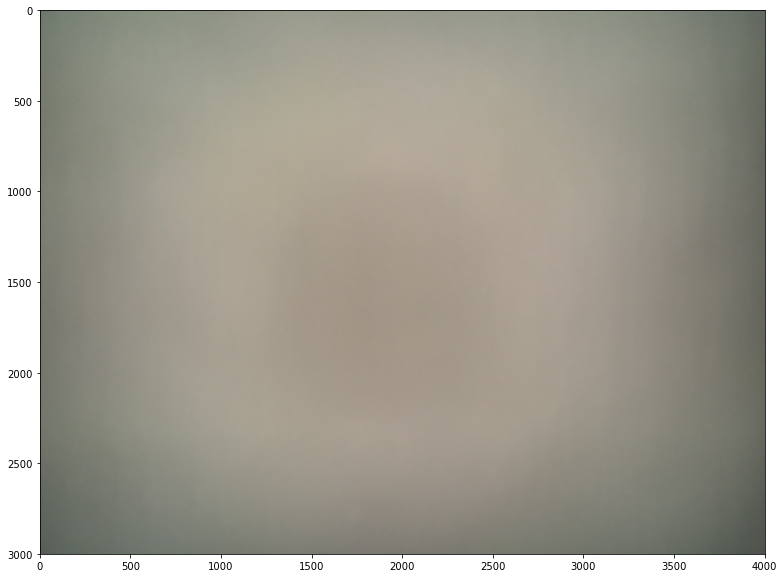

In [4]:
show_opencv_image(img)

## prepare data
As openCV color channels are in BGR order, we first convert the order of color channels from BGR to RGB, that is more intiutive when working with colors. Then we resphape the image in two dimensional array. An image loaded with opencv has three dimensions (h, w, #channels), so we convert it to two dimensional array (h*w, #channels). It is easier to work on 2D array than 3D array. Then we extract the values of each color channel.

In [5]:
def extract_rgb(image):
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_2d = img_rgb.reshape(img_rgb.shape[0]* img_rgb.shape[1], 3)
    red = img_2d[:,0]
    green = img_2d[:,1]
    blue = img_2d[:,2]
    return red, green, blue

In [14]:
r,g,b = extract_rgb(img)
r,g,b

(array([106, 106, 106, ...,  77,  77,  77], dtype=uint8),
 array([120, 120, 120, ...,  82,  82,  82], dtype=uint8),
 array([107, 107, 107, ...,  76,  76,  76], dtype=uint8))

## extract features

In [7]:
def compute_rg_bg_features(r, g, b):
    red = r.astype(float)
    green = g.astype(float)
    blue = b.astype(float)
    rg = red / green
    bg = blue / green
    return np.vstack((rg, bg)).T

In [8]:
def compute_rg_features(r, g, b):
    red = r.astype(float)
    green = g.astype(float)
    blue = b.astype(float)
    r_ = red / (red + green + blue)
    g_ = green / (red + green + blue)
    return np.vstack((r_, g_)).T

In [9]:
rg_bg_color_point = compute_rg_bg_features(r,g,b)
rg_bg_color_point

array([[ 0.88333333,  0.89166667],
       [ 0.88333333,  0.89166667],
       [ 0.88333333,  0.89166667],
       ..., 
       [ 0.93902439,  0.92682927],
       [ 0.93902439,  0.92682927],
       [ 0.93902439,  0.92682927]])

In [10]:
r_g_color_point = compute_rg_features(r,g,b)
r_g_color_point

array([[ 0.31831832,  0.36036036],
       [ 0.31831832,  0.36036036],
       [ 0.31831832,  0.36036036],
       ..., 
       [ 0.32765957,  0.34893617],
       [ 0.32765957,  0.34893617],
       [ 0.32765957,  0.34893617]])

### imputation 

When we work with KMeans algorithm, we have (h * w) rows corresponding pixels and each pixel will have two features, (R/G and B/G) or (r = R/(R+G+B) g = G/(R+G+B)). When divisor is zero, then we will have division by zero exception and corresponding outcome will be NaN. We would like to get rid of the NaN, for this purpose we will use imputer to replace the NaN with a sensible data.

In [19]:
def run_imputer(X):
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=True)
    imp_X = imp.fit_transform(X)
    return imp_X

In [20]:
rg_bg_ = run_imputer(rg_bg_color_point)
r_g_= run_imputer(r_g_color_point)

### Select which  feature to use:

In [21]:
features = r_g_

## KMeans
KMeans algorithm accepts number of clusters as an input. The function below accept a list of K that we want to give
as an input to algorithm and it returns the list of models. This allows us to run the algorithm once for the K values
we want to explore and later on we can work with the models further. We also provide input image as prepared above as an input to function. KMeans is going to cluster the each image pixel regarding the features we provide.

In [22]:
def explore_K(n_cluster_list, X):
    clt_ = list()
    for i in n_cluster_list:
        t0 = time.time()
        clt = KMeans(n_clusters=i).fit(X)
        t_diff = time.time() - t0 
        print "n_clusters: %d, %.2f min" % (i, t_diff/60.0)
        clt_.append(clt)
    return clt_

In [23]:
# KMeans is quite slow for 12M pixels, 
# therefore we are not going to explore more than 4 clusters, but feel free to try more clusters!

K_values= [2,3,4]
rg_bg_kmeans_model_list = explore_K(K_values, features)

n_clusters: 2, 1.11 min
n_clusters: 3, 1.46 min
n_clusters: 4, 1.66 min


In [24]:
rg_bg_kmeans_model_list

[KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0)]

## MiniBatchKMeans
We observe that processing 12M pixels takes a while even for small number of clusters. The average complexity is given by O(K n T), were n is the number of samples and T is the number of iteration. The worst case complexity is given by O(n^(K+2/p)) with n = n_samples, p = n_features. Instead of KMeans, we can use MiniBatchKMeans (http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html)

In [25]:
def explore_MiniBatchK(n_cluster_list, X):
    clt_ = list()
    for i in n_cluster_list:
        t0 = time.time()
        clt = MiniBatchKMeans(n_clusters=i).fit(X)
        t_diff = time.time() - t0 
        print "n_clusters: %d, %.2f min" % (i, t_diff/60.0)
        clt_.append(clt)
    return clt_

In [26]:
K_values= [2,3,4,5,6,7,8,9,10,11,12]
rg_bg_minibatch_model_list = explore_MiniBatchK(K_values, features)

n_clusters: 2, 0.27 min
n_clusters: 3, 0.26 min
n_clusters: 4, 0.27 min
n_clusters: 5, 0.27 min
n_clusters: 6, 0.27 min
n_clusters: 7, 0.58 min
n_clusters: 8, 0.28 min
n_clusters: 9, 0.28 min
n_clusters: 10, 0.28 min
n_clusters: 11, 0.32 min
n_clusters: 12, 0.47 min


In [27]:
rg_bg_minibatch_model_list

[MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
         init_size=None, max_iter=100, max_no_improvement=10, n_clusters=2,
         n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
         verbose=0),
 MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
         init_size=None, max_iter=100, max_no_improvement=10, n_clusters=3,
         n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
         verbose=0),
 MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
         init_size=None, max_iter=100, max_no_improvement=10, n_clusters=4,
         n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
         verbose=0),
 MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
         init_size=None, max_iter=100, max_no_improvement=10, n_clusters=5,
         n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
         verbose=0),
 MiniBatchKMeans(batch_size=100, com

## plot centroids

In [36]:
#todo: plots upto 8 clusters, make it more generic
def plot_cluster_centroids(clt, x_label="R/G", y_label="B/G"):
    """
    plot the centroids
    """
    marker_list = ['o', 'v', 's', '*', '+', 'x', '8', 'D']
    for i in range(len(clt.cluster_centers_)):
        cluster_centers = "%.3f, %.3f" % (clt.cluster_centers_[i,0], clt.cluster_centers_[i,1])
        plt.scatter(clt.cluster_centers_[i,0],
                    clt.cluster_centers_[i,1], 
                    marker=marker_list[i], 
                    s=200,
                    color='k', 
                    label=str(i) + " (" + str(cluster_centers) + " )")
    plt.legend()
    plt.title("centroids")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid()

## plot all clusters with centroids

In [40]:
#todo: plots upto 8 clusters, make it more generic
def plot_all_samples(clt, X, x_label="R/G", y_label="B/G"):
    """
    plot the centroids and clusters (of pixels) with different color and shape
    """
    marker_list = ['o', 'v', 's', '*', '+', 'x', '8', 'D']
    color_list = ['k', 'grey', 'r', 'g', 'b', 'c', 'm', 'y']
    labels = np.unique(clt.labels_)
    for l in labels:
        index = np.where(clt.labels_ == labels[l])
        plt.scatter(X[index, 0], 
                    X[index, 1], 
                    marker=marker_list[l], 
                    color=color_list[l])
        
    # plot centroids
    for i in range(len(clt.cluster_centers_)):
        cluster_centers = "%.3f, %.3f" % (clt.cluster_centers_[i,0], clt.cluster_centers_[i,1])
        plt.scatter(clt.cluster_centers_[i,0],
                    clt.cluster_centers_[i,1], 
                    marker=marker_list[i], s=200,
                    color='k', 
                    label=str(i) + " (" + str(cluster_centers) + " )")
    plt.legend()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title("clusters")
    plt.grid()

### Plot clusters computed with KMeans

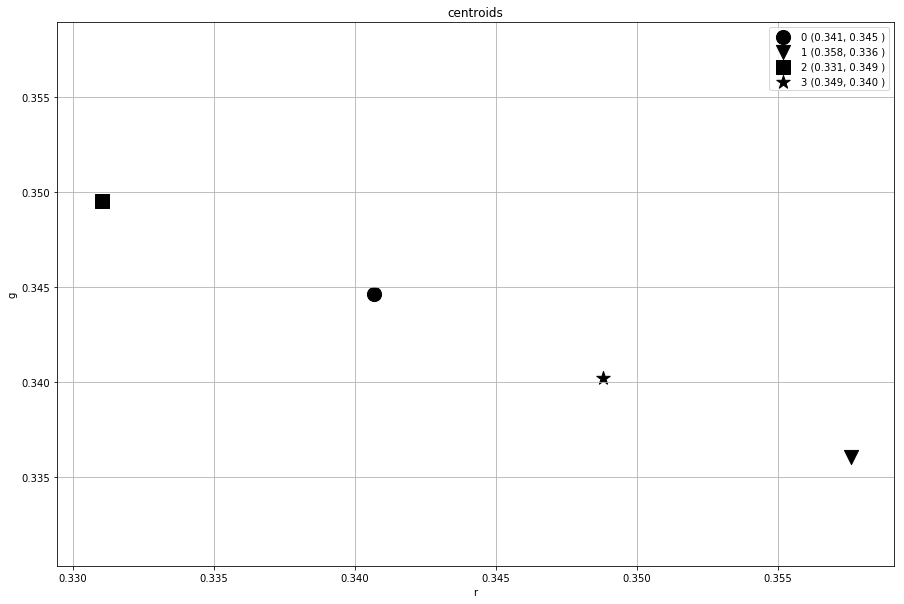

In [41]:
# We can select a model from the list and plot the centroids
plot_cluster_centroids(rg_bg_kmeans_model_list[2], x_label="r", y_label="g")

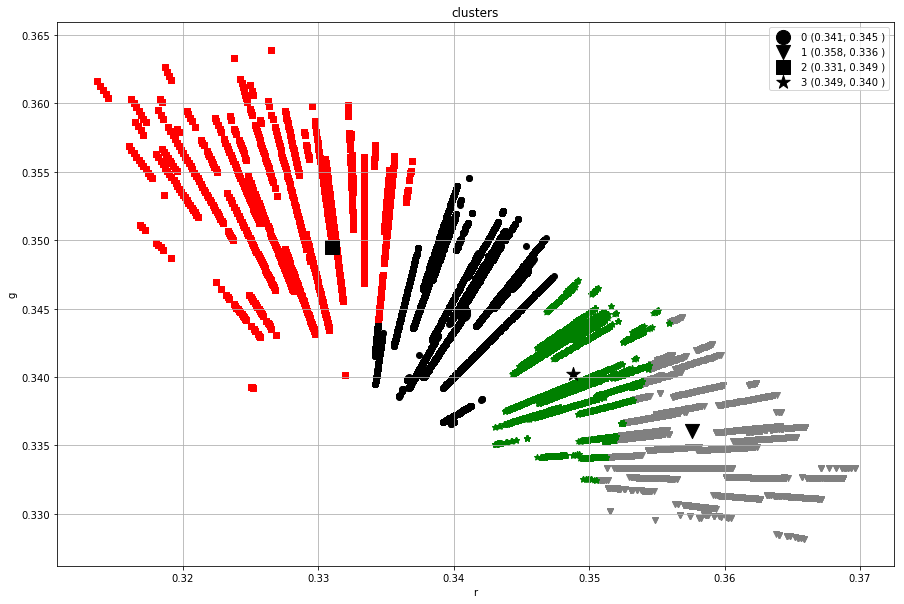

In [43]:
# plotting can take a while! 
plot_all_samples(rg_bg_kmeans_model_list[2], features,  x_label="r", y_label="g")

### Plot clusters computed with MiniBatchKMeans

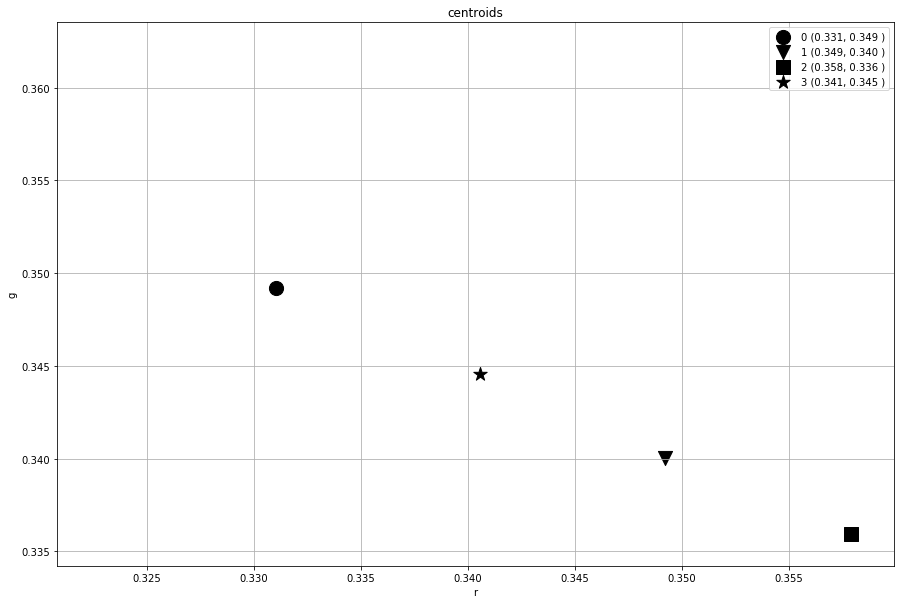

In [45]:
plot_cluster_centroids(rg_bg_minibatch_model_list[2], x_label="r", y_label="g")

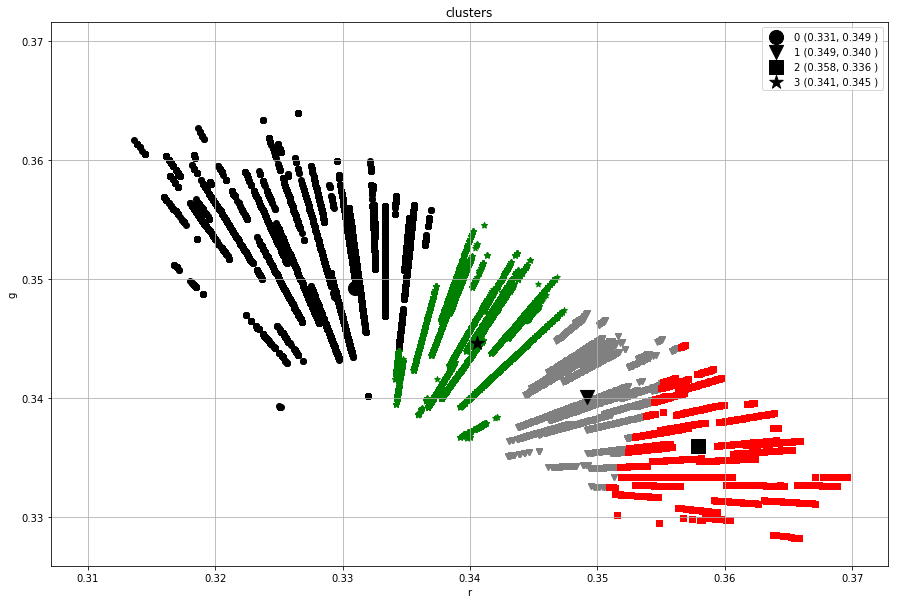

In [46]:
plot_all_samples(rg_bg_minibatch_model_list[2], features, x_label="r", y_label="g")

## show the clusters in original image dimension
It would be useful to visualize which pixel in an image belongs to which cluster.

In [51]:
#todo: plots upto 8 clusters, make it more generic
def plot_clusters_2d(clt, image):
    red = [255, 0, 0] 
    green = [0, 128, 0] 
    blue = [0, 0, 255]
    cyan = [0, 255, 255]
    magenta = [255, 0, 255]
    yellow = [255, 255, 0]
    black = [0,0,0]
    grey = [128,128,128]
    rgb_colors = [black, grey, red, green, blue, cyan, magenta, yellow]
    
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_2d = img_rgb.reshape(img_rgb.shape[0]* img_rgb.shape[1], 3)
    labels = np.unique(clt.labels_)
    for l in labels:
        index = np.where(clt.labels_ == labels[l])
        img_2d[index] = rgb_colors[l]
    return img_2d.reshape(img_rgb.shape[0], img_rgb.shape[1], 3)

### KMeans

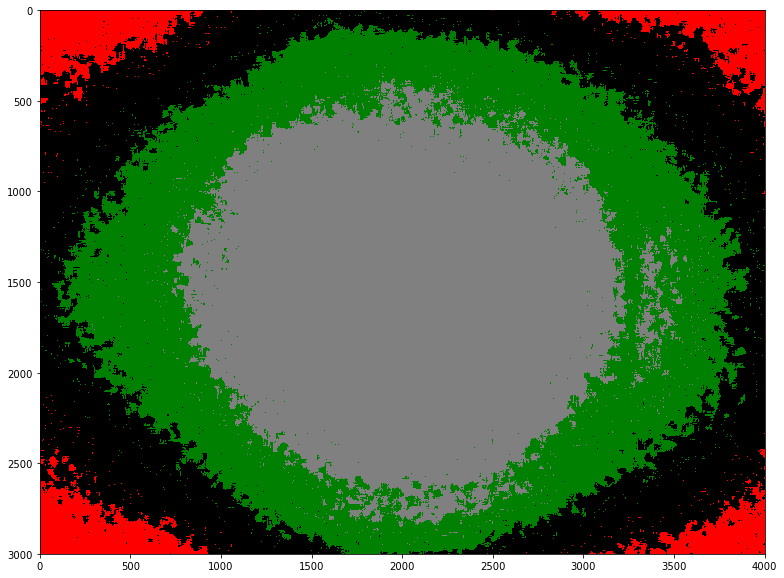

In [52]:
plt.imshow(plot_clusters_2d(rg_bg_kmeans_model_list[2], img))

### MiniBatchKMeans

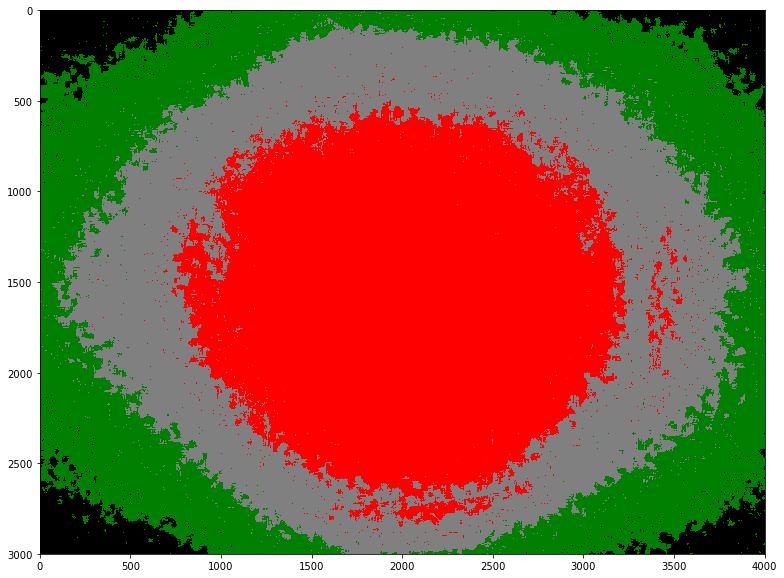

In [53]:
plt.imshow(plot_clusters_2d(rg_bg_minibatch_model_list[2], img))

# finding the elbow point
Which K is the best to use. One straightforward method is elbow method. (https://en.wikipedia.org/wiki/Elbow_method_(clustering)). Checking the inertia (sum of squared distances of samples to their closest cluster center.) vs. K can give an idea about elbow point. Elbow point is the point where you start to observe diminishing returns.
The function below plot the squared root of inertia vs K.

In [56]:
# TODO: find a new inertia_ which provides inertia for each class
# I would like to divide sum of squares with the number of cluster members to find average variance
def plot_k_vs_inertia(clt_list):
    for i, v in enumerate(clt_list):
        plt.plot(v.n_clusters, np.sqrt(v.inertia_), '-o')
    plt.grid()
    plt.xlabel("number of clusters (K)")
    plt.ylabel("inertia (total distance)")

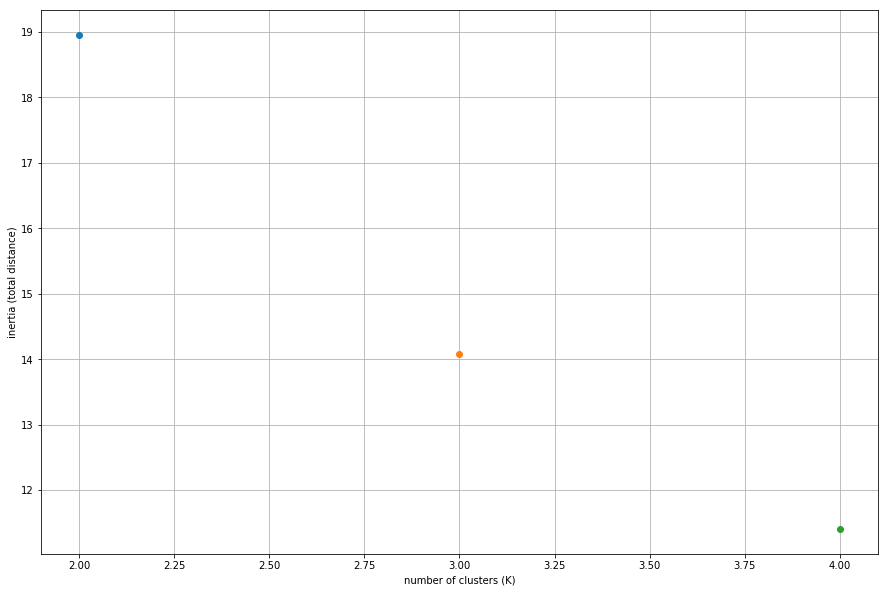

In [57]:
plot_k_vs_inertia(rg_bg_kmeans_model_list)

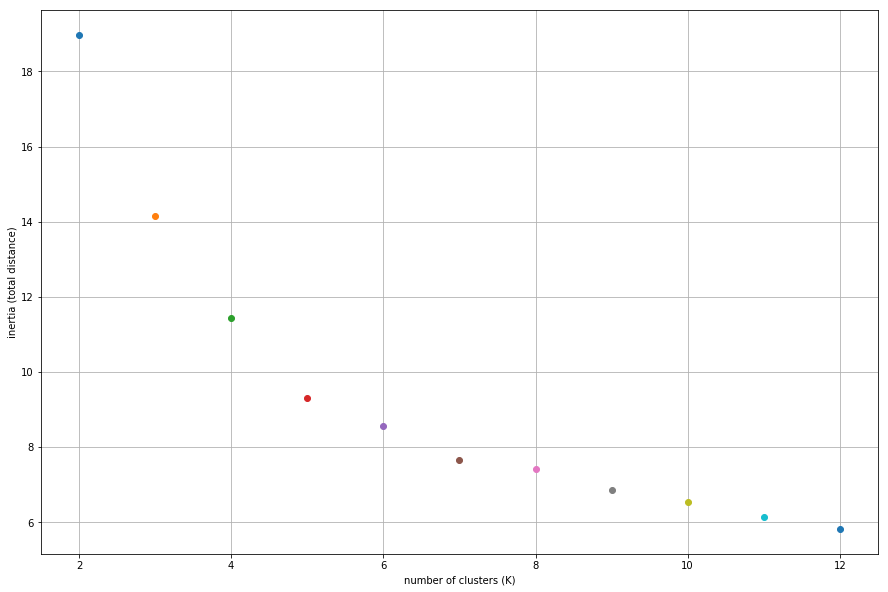

In [58]:
plot_k_vs_inertia(rg_bg_minibatch_model_list)

## histogram
We can also plot the number of pixels belonging to each cluster by using histogram.

In [59]:
def histogram_color_point(clt):
    num_labels= np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins=num_labels)
    plt.plot(hist)
    plt.scatter(arange(0, hist.shape[0]), hist)
    plt.grid()
    plt.xlabel("cluster label")
    plt.ylabel("# of points in the cluster")
    return hist

array([3355402, 4228598,  727352, 3688648])

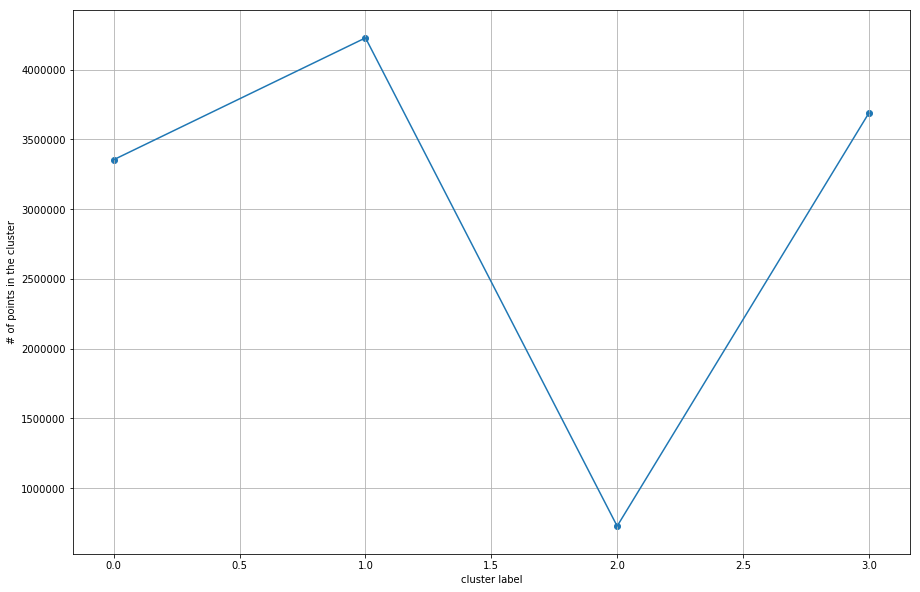

In [60]:
histogram_color_point(rg_bg_kmeans_model_list[2])

array([ 728906, 3914557, 4002689, 3353848])

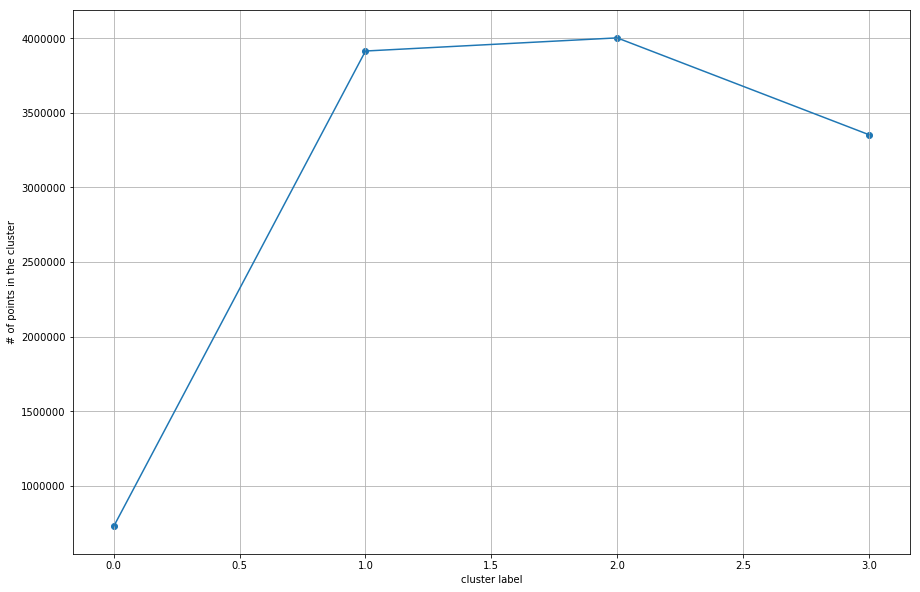

In [61]:
histogram_color_point(rg_bg_minibatch_model_list[2])

# Part 2: Intensity analysis of an image pixels with KMeans
We can use sum of rgb or only green channel values.
Let's use sum of rgb values as feature.

In [86]:
def compute_intensity_feature(r,g,b):
    sum_rgb = r.astype(float) + g.astype(float) + b.astype(float)
    return sum_rgb.reshape(sum_rgb.shape[0], 1)

In [87]:
# Lets use the same input image
r, g, b = extract_rgb(img)

In [88]:
r,g,b

(array([106, 106, 106, ...,  77,  77,  77], dtype=uint8),
 array([120, 120, 120, ...,  82,  82,  82], dtype=uint8),
 array([107, 107, 107, ...,  76,  76,  76], dtype=uint8))

In [89]:
image_intensity = compute_intensity_feature(r,g,b)

In [90]:
image_intensity

array([[ 333.],
       [ 333.],
       [ 333.],
       ..., 
       [ 235.],
       [ 235.],
       [ 235.]])

### KMeans

In [91]:
clt_kmeans_model_intensity = explore_K([2,3,4], image_intensity)

n_clusters: 2, 0.71 min
n_clusters: 3, 1.21 min
n_clusters: 4, 1.99 min


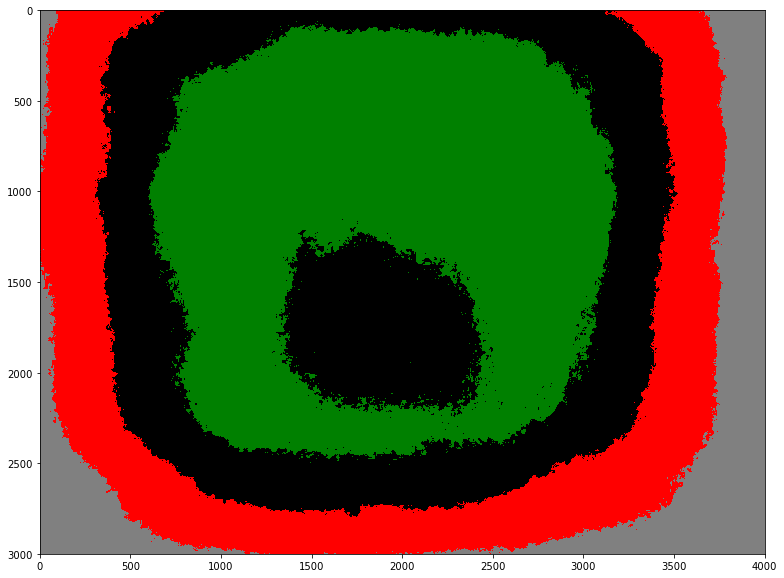

In [92]:
plt.imshow(plot_clusters_2d(clt_kmeans_model_intensity[2], img))

### MiniBatchKMeans

In [93]:
clt_minibatch_model_intensity = explore_MiniBatchK([2,3,4,5,6], image_intensity)

n_clusters: 2, 0.27 min
n_clusters: 3, 0.32 min
n_clusters: 4, 0.26 min
n_clusters: 5, 0.30 min
n_clusters: 6, 0.32 min


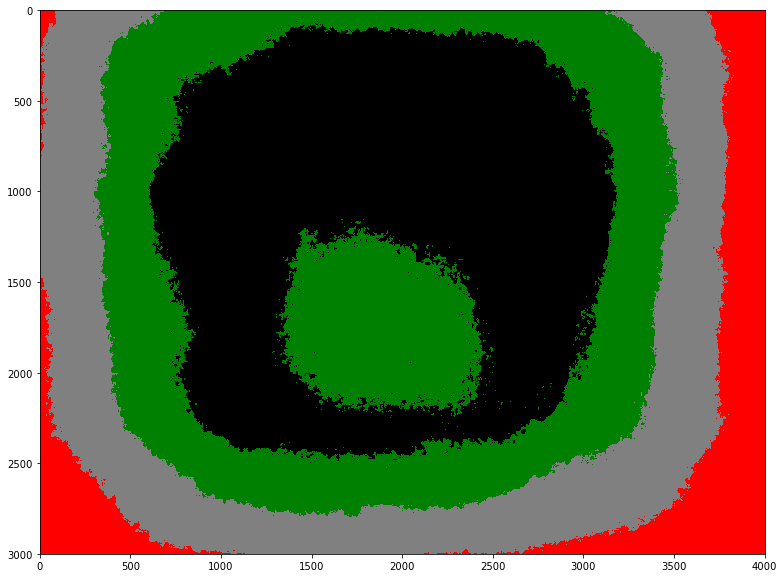

In [94]:
plt.imshow(plot_clusters_2d(clt_minibatch_model_intensity[2], img))